
**1. Setup: Environment, Config, Seed**

In [1]:
# ===== Step 1 — Environment Setup (Colab) =====
import sys, subprocess, math, time, random
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# (Optional) ensure datasets lib is present (for WikiText-2 in Step 2)
try:
    import datasets  # noqa
except ImportError:
    print("Installing 🤗 datasets...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "datasets"])
    import datasets  # noqa

# Plot defaults
plt.rcParams["figure.figsize"] = (6, 4)

# Device (GPU if healthy, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device detected:", device)
if device.type == "cuda":
    try:
        _ = torch.zeros(1, device="cuda") + 1
        torch.cuda.synchronize()
        print("CUDA is available and healthy.")
    except Exception as e:
        print("CUDA issue -> falling back to CPU:", repr(e))
        device = torch.device("cpu")

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Default hyperparams (we'll use fast mode later)
EPOCHS_PRE  = 1     # fast pretrain
EPOCHS_SFT  = 1     # fast SFT
LR_PRE      = 3e-3
LR_SFT      = 3e-3
BATCH_ACCUM = 1
BLOCK_SIZE  = 128   # will be adjusted based on data
BATCH_SIZE  = 32
MAX_NEW_TOK = 100
GEN_TEMPERATURE = 0.9

print({
    "EPOCHS_PRE": EPOCHS_PRE, "EPOCHS_SFT": EPOCHS_SFT,
    "LR_PRE": LR_PRE, "LR_SFT": LR_SFT,
    "BLOCK_SIZE": BLOCK_SIZE, "BATCH_SIZE": BATCH_SIZE,
    "MAX_NEW_TOK": MAX_NEW_TOK, "TEMP": GEN_TEMPERATURE
})


Device detected: cuda
CUDA is available and healthy.
{'EPOCHS_PRE': 1, 'EPOCHS_SFT': 1, 'LR_PRE': 0.003, 'LR_SFT': 0.003, 'BLOCK_SIZE': 128, 'BATCH_SIZE': 32, 'MAX_NEW_TOK': 100, 'TEMP': 0.9}


**Step 2: Dataset & tokenizer with WikiText-2**

In [2]:
# ===== Step 2 — Dataset & Character Tokenizer (WikiText-2) =====
from datasets import load_dataset

# 1) Load WikiText-2 (raw)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
print(dataset)

# 2) Concatenate split text
train_text = " ".join(dataset["train"]["text"])
val_text   = " ".join(dataset["validation"]["text"])

print("Train chars:", len(train_text))
print("Val chars:", len(val_text))

# 3) Character-level vocab built from TRAIN text (to avoid leakage)
chars = sorted(list(set(train_text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s: str):
    # map string -> list[int] (unknown chars skipped)
    return [stoi[c] for c in s if c in stoi]

def decode(ids):
    # map list[int] -> string
    return "".join(itos[i] for i in ids if i in itos)

# 4) Fast-mode slices (to keep training quick in Colab)
SLICE_TRAIN = 20_000   # characters from train
SLICE_VAL   = 4_000    # characters from val
train_ids_small = encode(train_text[:SLICE_TRAIN])
val_ids_small   = encode(val_text[:SLICE_VAL])

print("Vocab size:", len(stoi))
print("Sliced lengths -> train_ids_small:", len(train_ids_small), " val_ids_small:", len(val_ids_small))

# 5) Quick round-trip check
sample_ids = train_ids_small[:80]
print("Encoded sample (len={}):".format(len(sample_ids)), sample_ids[:20], "...")
print("Decoded sample:", decode(sample_ids))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
Train chars: 10929707
Val chars: 1145909
Vocab size: 1013
Sliced lengths -> train_ids_small: 20000  val_ids_small: 4000
Encoded sample (len=80): [1, 1, 30, 1, 55, 66, 77, 76, 90, 83, 74, 66, 1, 36, 73, 83, 80, 79, 74, 68] ...
Decoded sample:   = Valkyria Chronicles III = 
   Senjō no Valkyria 3 : Unrecorded Chronicles ( 


**Step 3: Tiny GPT-like mode**

In [3]:
# ===== Step 3 — Tiny GPT-like (character-level, fast) =====
import torch.nn as nn
import torch

# We'll use a compact transformer so it trains quickly in Colab.
# We'll set BLOCK_SIZE in Step 4 when we finalize the loaders; default to 64 here.
BLOCK_SIZE = 64  # (will be re-used by the loaders next step)

class TinyGPTFast(nn.Module):
    def __init__(self, vocab_size, n_embd=64, n_heads=2, n_layers=1, block_size=BLOCK_SIZE):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb   = nn.Embedding(block_size, n_embd)
        enc_layer = nn.TransformerEncoderLayer(d_model=n_embd, nhead=n_heads, batch_first=True)
        self.encoder   = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx):
        B, T = idx.shape
        # safety clamp in case a sequence is longer than configured block size
        if T > self.block_size:
            idx = idx[:, :self.block_size]
            T = self.block_size
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)  # (1, T)
        x = self.token_emb(idx) + self.pos_emb(pos)               # (B, T, C)
        x = self.encoder(x)                                       # (B, T, C)
        x = self.ln_f(x)
        return self.head(x)                                       # (B, T, V)

def count_params(m): return sum(p.numel() for p in m.parameters() if p.requires_grad)

# Instantiate model now (we'll re-use this for pre-training and SFT)
model = TinyGPTFast(vocab_size=len(stoi), block_size=BLOCK_SIZE).to(device)
print("Model:", model.__class__.__name__, "| Params:", count_params(model), "| Device:", device)


Model: TinyGPTFast | Params: 416053 | Device: cuda


**Step 4: Safe data loaders (and finalize BLOCK_SIZE).**

In [4]:
# ===== Step 4 — Safe DataLoaders for LM (fast) =====
from torch.utils.data import Dataset, DataLoader
import torch

# We’ll use the BLOCK_SIZE defined with the model (64). Adjust if needed.
assert "train_ids_small" in globals() and "val_ids_small" in globals(), "Run Step 2 first."
assert "BLOCK_SIZE" in globals(), "Run Step 3 first (defines BLOCK_SIZE)."

class CharLMDataset(Dataset):
    def __init__(self, ids, block_size=BLOCK_SIZE):
        self.ids = ids
        self.block = block_size
    def __len__(self):
        return max(0, len(self.ids) - self.block - 1)
    def __getitem__(self, idx):
        chunk = self.ids[idx : idx + self.block + 1]
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:],  dtype=torch.long)
        return x, y

BATCH_SIZE = 16  # small to keep it quick
train_ds = CharLMDataset(train_ids_small, BLOCK_SIZE)
val_ds   = CharLMDataset(val_ids_small,   BLOCK_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("train_len:", len(train_ds), " val_len:", len(val_ds))
print("train_batches:", len(train_loader), " val_batches:", len(val_loader))

# One-batch sanity check
xb, yb = next(iter(train_loader))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape), "| max token:", int(xb.max().item()), "| vocab:", len(stoi))
assert int(xb.max().item()) < len(stoi), "Token id >= vocab size — check tokenizer."
assert xb.shape[1] <= BLOCK_SIZE, "Seq length exceeds model BLOCK_SIZE."
with torch.no_grad():
    _ = TinyGPTFast(vocab_size=len(stoi), block_size=BLOCK_SIZE).cpu()(xb)
print("Single-batch CPU forward passed.")


train_len: 19935  val_len: 3935
train_batches: 1246  val_batches: 246
Batch shapes: (16, 64) (16, 64) | max token: 90 | vocab: 1013
Single-batch CPU forward passed.


**Step 5: Pre-training (unsupervised LM).**

CUDA OK
Using device: cuda
train_batches: 1246  val_batches: 246
Batch shapes: (16, 64) (16, 64)
[Pre] Epoch 1/3
   ran 50 batches
   ran 20 batches
   losses -> train=3.2896 val=2.7705
[Pre] Epoch 2/3
   ran 50 batches
   ran 20 batches
   losses -> train=2.5187 val=2.5060
[Pre] Epoch 3/3
   ran 50 batches
   ran 20 batches
   losses -> train=1.4280 val=0.4925
Total pretrain time: 0.9s


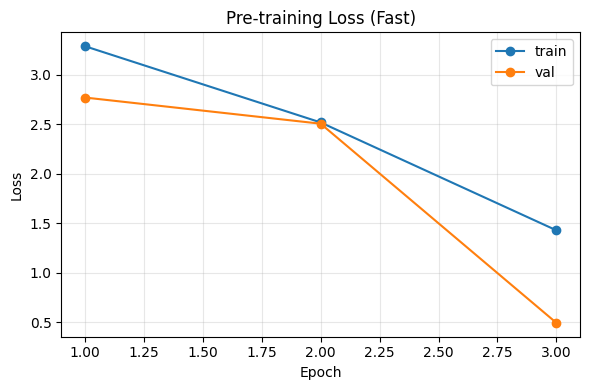

Saved plot -> pretrain_loss.png
Pre-train Val Loss: 0.492509039491415 | PPL: 1.6364169080566706

=== Pre-train sample ===
The history of AI wtsio y fiooppiy iyo ypphripiy pou , lre ioy hooeoooo uoeoooooeoopoooiiooeeeoooi


In [8]:
# ===== Step 5 — Pre-training (SAFE, fast, self-contained) =====
import math, time, torch, matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# --- 0) Preconditions & fallbacks ---
assert 'encode' in globals() and 'decode' in globals(), "Tokenizer not found. Please run Steps 1–2."
assert 'train_ids_small' in globals() and 'val_ids_small' in globals(), "Data slices missing. Please re-run Step 2."

# Device (fall back to CPU if CUDA is upset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    try:
        _ = torch.zeros(1, device=device) + 1
        torch.cuda.synchronize()
        print("CUDA OK")
    except Exception as e:
        print("CUDA issue -> using CPU:", repr(e))
        device = torch.device("cpu")
print("Using device:", device)

# --- 1) DataLoaders (rebuild safely in case earlier cell wasn't run) ---
BLOCK_SIZE = 64
BATCH_SIZE = 16

class CharLMDataset(Dataset):
    def __init__(self, ids, block_size=BLOCK_SIZE):
        self.ids = ids; self.block = block_size
    def __len__(self): return max(0, len(self.ids) - self.block - 1)
    def __getitem__(self, idx):
        chunk = self.ids[idx:idx+self.block+1]
        x = torch.tensor(chunk[:-1]).long()
        y = torch.tensor(chunk[1:]).long()
        return x, y

train_loader = DataLoader(CharLMDataset(train_ids_small, BLOCK_SIZE), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = DataLoader(CharLMDataset(val_ids_small,   BLOCK_SIZE), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("train_batches:", len(train_loader), " val_batches:", len(val_loader))
xb, yb = next(iter(train_loader))
print("Batch shapes:", tuple(xb.shape), tuple(yb.shape))

# If val is empty, reuse tiny slice from train as val to avoid NaN plots
if len(val_loader) == 0:
    print("Val loader empty -> creating a tiny validation set from train slice.")
    val_ids_fallback = train_ids_small[: 4_000]
    val_loader = DataLoader(CharLMDataset(val_ids_fallback, BLOCK_SIZE), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# --- 2) Tiny model (recreate safely) ---
if 'stoi' not in globals():
    raise AssertionError("Vocabulary not found. Re-run Step 2.")

class TinyGPTFast(nn.Module):
    def __init__(self, vocab_size, n_embd=64, n_heads=2, n_layers=1, block_size=BLOCK_SIZE):
        super().__init__()
        self.block_size = block_size
        self.token_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb   = nn.Embedding(block_size, n_embd)
        enc_layer = nn.TransformerEncoderLayer(d_model=n_embd, nhead=n_heads, batch_first=True)
        self.encoder   = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
    def forward(self, idx):
        B,T = idx.shape
        if T > self.block_size:
            idx = idx[:, :self.block_size]; T = self.block_size
        pos = torch.arange(0, T, device=idx.device).unsqueeze(0)
        x = self.token_emb(idx) + self.pos_emb(pos)
        x = self.encoder(x)
        x = self.ln_f(x)
        return self.head(x)

try:
    vocab_size = len(stoi)
except:
    vocab_size = len(set(train_ids_small))  # fallback

model = TinyGPTFast(vocab_size, block_size=BLOCK_SIZE)
try:
    model = model.to(device)
except Exception as e:
    print("Model .to(device) failed -> using CPU:", repr(e))
    device = torch.device("cpu")
    model = model.to(device)

# --- 3) Training helpers (capped for speed) ---
EPOCHS_PRE = 3          # >1 epoch so curve is visible
LR_PRE = 3e-3
MAX_BATCHES_TRAIN = 50
MAX_BATCHES_VAL   = 20

def run_epoch_lm(model, loader, optimizer=None, max_batches=None):
    model.train(optimizer is not None)
    total, n = 0.0, 0
    for bi, (x,y) in enumerate(loader):
        if max_batches is not None and bi >= max_batches: break
        x, y = x.to(device), y.to(device)
        if optimizer: optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
        if optimizer:
            loss.backward(); optimizer.step()
        total += loss.item(); n += 1
    print(f"   ran {n} batches")
    return total / max(1, n)

def perplexity_from_loss(val_loss):
    return math.exp(val_loss) if (val_loss is not None and not math.isnan(val_loss)) else float("nan")

@torch.no_grad()
def generate_autoregressive(model, encode, decode, prompt_text, max_new_tokens=80, temperature=0.9):
    model.eval()
    idx = torch.tensor([encode(prompt_text)], dtype=torch.long, device=device)
    for _ in range(max_new_tokens):
        logits = model(idx)[:, -1, :]
        if temperature != 1.0:
            logits = logits / max(1e-6, temperature)
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, 1)
        idx = torch.cat([idx, next_id], dim=1)
    return decode(idx[0].tolist())

# --- 4) Train + log ---
opt_pre = torch.optim.AdamW(model.parameters(), lr=LR_PRE)
history_pre = {"train": [], "val": []}

t0 = time.time()
for ep in range(1, EPOCHS_PRE+1):
    print(f"[Pre] Epoch {ep}/{EPOCHS_PRE}")
    tr = run_epoch_lm(model, train_loader, optimizer=opt_pre, max_batches=MAX_BATCHES_TRAIN)
    va = run_epoch_lm(model, val_loader,   optimizer=None,   max_batches=MAX_BATCHES_VAL)
    history_pre["train"].append(tr); history_pre["val"].append(va)
    print(f"   losses -> train={tr:.4f} val={va:.4f}")
print(f"Total pretrain time: {time.time()-t0:.1f}s")

# --- 5) Plot (markers so even few points show) ---
plt.figure()
plt.plot(range(1, len(history_pre["train"])+1), history_pre["train"], marker="o", label="train")
plt.plot(range(1, len(history_pre["val"])+1),   history_pre["val"],   marker="o", label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Pre-training Loss (Fast)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("pretrain_loss.png", dpi=150)
plt.show()
print("Saved plot -> pretrain_loss.png")

# --- 6) Reportable metrics + sample ---
ppl_pre = perplexity_from_loss(history_pre["val"][-1])
print("Pre-train Val Loss:", history_pre["val"][-1], "| PPL:", ppl_pre)

print("\n=== Pre-train sample ===")
print(generate_autoregressive(model, encode, decode, "The history of AI "))


**Step 6: SFT dataset construction**

In [9]:
# ===== Step 6 — SFT Dataset (instruction → answer pairs), Fast =====
# Uses: train_ids_small (from Step 2), encode/decode, device
from torch.utils.data import Dataset, DataLoader
import torch

assert "train_ids_small" in globals(), "Run Step 2 first."

# Hyperparams for SFT pair construction
K = 64          # length of "instruction" segment (in characters/tokens)
STRIDE = 128    # how far to slide the window each pair
SFT_BATCH_SIZE = 32
IGNORE_INDEX = -100

class SFTPairsCharDataset(Dataset):
    """
    Produces tuples: (X, Y_masked, instr_ids, targ_ids)
      - instr_ids: K tokens
      - targ_ids : K tokens immediately following instr
      - X = instr + targ[:-1]
      - Y_masked = [ignore over instr[:-1]] + targ
    """
    def __init__(self, ids_list, split="train", split_ratio=0.9, K=K, stride=STRIDE):
        assert split in ("train", "val")
        self.K = K
        pairs = []
        i = 0
        n = len(ids_list)
        while i + 2*K <= n:
            instr = ids_list[i : i+K]
            targ  = ids_list[i+K : i+2*K]
            pairs.append((instr, targ))
            i += stride
        cut = int(len(pairs) * split_ratio)
        self.pairs = pairs[:cut] if split == "train" else pairs[cut:]

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        instr, targ = self.pairs[idx]
        x = torch.tensor(instr + targ[:-1], dtype=torch.long)  # input
        y = torch.tensor(instr[1:] + targ,   dtype=torch.long)  # labels, aligned
        y_masked = y.clone()
        # ignore loss on instruction region (except keep alignment by ignoring first K-1)
        y_masked[: self.K - 1] = IGNORE_INDEX
        return x, y_masked, instr, targ

def sft_collate(batch, pad_id=0, ignore_index=IGNORE_INDEX):
    xs, ys, instrs, targs = zip(*batch)
    maxL = max(x.size(0) for x in xs)
    X = torch.full((len(batch), maxL), pad_id, dtype=torch.long)
    Y = torch.full((len(batch), maxL), ignore_index, dtype=torch.long)
    for i, (x, y) in enumerate(zip(xs, ys)):
        X[i, -x.size(0):] = x
        Y[i, -y.size(0):] = y
    return X, Y, instrs, targs

# Build train/val SFT datasets + loaders from the TRAIN slice
sft_train_ds = SFTPairsCharDataset(train_ids_small, split="train", split_ratio=0.9, K=K, stride=STRIDE)
sft_val_ds   = SFTPairsCharDataset(train_ids_small, split="val",   split_ratio=0.9, K=K, stride=STRIDE)

sft_train_loader = DataLoader(sft_train_ds, batch_size=SFT_BATCH_SIZE, shuffle=True,  collate_fn=sft_collate)
sft_val_loader   = DataLoader(sft_val_ds,   batch_size=SFT_BATCH_SIZE, shuffle=False, collate_fn=sft_collate)

print(f"SFT pairs -> train: {len(sft_train_ds)} | val: {len(sft_val_ds)}  (K={K}, stride={STRIDE})")

# Peek at one batch to verify shapes & masking
try:
    Xb, Yb, instrs, targs = next(iter(sft_train_loader))
    print("Batch shapes: X", tuple(Xb.shape), "Y", tuple(Yb.shape))
    print("Ignore_index count in first batch:", int((Yb == IGNORE_INDEX).sum().item()))
    # Show a decoded example
    i0 = 0
    instr_text = decode(instrs[i0])
    targ_text  = decode(targs[i0])
    print("\n--- SFT decoded example ---")
    print("[INSTRUCTION]:", repr(instr_text))
    print("[TARGET     ]:", repr(targ_text))
except StopIteration:
    print("No SFT batches available. Increase SLICE_TRAIN or reduce K/STRIDE.")


SFT pairs -> train: 140 | val: 16  (K=64, stride=128)
Batch shapes: X (32, 127) Y (32, 127)
Ignore_index count in first batch: 2016

--- SFT decoded example ---
[INSTRUCTION]: "uring the game 's ending . The battle themes were designed aroun"
[TARGET     ]: 'd the concept of a " modern battle " divorced from a fantasy sce'


**Step 7: SFT training**

[SFT] Epoch 1/1  train=0.4686  val=0.4327
SFT time: 0.1s


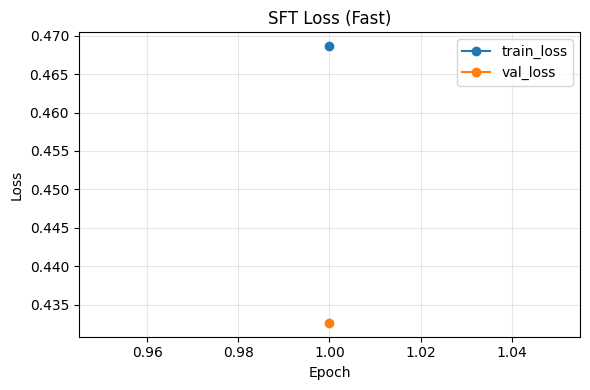

Saved plot -> sft_loss.png
SFT Val Loss: 0.4326549768447876 | PPL: 1.541344329464692

=== SFT Example 1 ===
[INSTRUCTION]: ' @-@ playing video game for the PlayStation 4 that forms the beg'
[TARGET     ]: 'inning of a new series within the Valkyria franchise . \n   = = ='
[GENERATED  ]: ''

=== SFT Example 2 ===
[INSTRUCTION]: ' Adaptations = = = \n   Valkyria Chronicles 3 was adapted into a '
[TARGET     ]: 'two @-@ episode original video animation series in the same year'
[GENERATED  ]: ''

=== SFT Example 3 ===
[INSTRUCTION]: ' of its release . Titled Senjō no Valkyria 3 : Taga Tame no Jūsō'
[TARGET     ]: ' ( 戦場のヴァルキュリア３ 誰がための銃瘡 , lit . Valkyria of the Battlefield 3 : T'
[GENERATED  ]: ''


In [11]:
# ===== Step 7 — SFT Training (Fast, single cell, length-safe) =====
import time, math, torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- Config (fast) ---
EPOCHS_SFT = 1          # bump to 2–3 if you want a longer curve
LR_SFT = 3e-3
BATCH_ACCUM = 1
IGNORE_INDEX = -100
SHOW_EXAMPLES = 3

# --- Preconditions ---
assert "sft_train_loader" in globals() and "sft_val_loader" in globals(), "Run Step 6 first."
assert "model" in globals(), "Run Steps 3–5 first."
Tm = getattr(model, "block_size", 64)  # model's max sequence length

# --- Runner that slices both X and Y to model.block_size so shapes match ---
def run_epoch_sft(model, loader, optimizer=None, ignore_index=IGNORE_INDEX, max_batches=None):
    train_mode = optimizer is not None
    model.train(train_mode)
    total, n = 0.0, 0
    for bi, (X, Y, _, _) in enumerate(loader):
        if (max_batches is not None) and (bi >= max_batches): break
        # Keep the last Tm tokens so X, Y match model output length
        if X.size(1) > Tm:
            X = X[:, -Tm:]
            Y = Y[:, -Tm:]
        X, Y = X.to(device), Y.to(device)
        if train_mode: optimizer.zero_grad()
        logits = model(X)  # (B, Tm, V)
        loss = F.cross_entropy(
            logits.reshape(-1, logits.size(-1)),
            Y.reshape(-1),
            ignore_index=ignore_index
        )
        if train_mode:
            (loss / BATCH_ACCUM).backward()
            optimizer.step()
        total += loss.item(); n += 1
    return total / max(1, n)

def perplexity_from_loss(loss):
    return math.exp(loss) if (loss is not None and not math.isnan(loss)) else float("nan")

# --- Train (continue from pre-trained weights) ---
opt_sft = torch.optim.AdamW(model.parameters(), lr=LR_SFT)
history_sft = {"train_loss": [], "val_loss": []}

t0 = time.time()
for ep in range(1, EPOCHS_SFT + 1):
    tr = run_epoch_sft(model, sft_train_loader, optimizer=opt_sft)
    va = run_epoch_sft(model, sft_val_loader,   optimizer=None)
    history_sft["train_loss"].append(tr); history_sft["val_loss"].append(va)
    print(f"[SFT] Epoch {ep}/{EPOCHS_SFT}  train={tr:.4f}  val={va:.4f}")
print(f"SFT time: {time.time()-t0:.1f}s")

# --- Plot with markers (visible even for 1 epoch) and save ---
plt.figure()
plt.plot(range(1, len(history_sft["train_loss"])+1), history_sft["train_loss"], marker="o", label="train_loss")
plt.plot(range(1, len(history_sft["val_loss"])+1),   history_sft["val_loss"],   marker="o", label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("SFT Loss (Fast)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("sft_loss.png", dpi=150); plt.show()
print("Saved plot -> sft_loss.png")

# --- PPL from final val loss ---
ppl_sft = perplexity_from_loss(history_sft["val_loss"][-1])
print("SFT Val Loss:", history_sft["val_loss"][-1], "| PPL:", ppl_sft)

# --- Qualitative samples: instruction vs target vs generated completion ---
@torch.no_grad()
def generate_completion(model, instr_text, max_new_tokens=64, temperature=0.9):
    model.eval()
    idx = torch.tensor([encode(instr_text)], dtype=torch.long, device=device)
    for _ in range(max_new_tokens):
        logits = model(idx)[:, -1, :]
        if temperature != 1.0: logits = logits / max(1e-6, temperature)
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, 1)
        idx = torch.cat([idx, next_id], dim=1)
        # Keep context within model.block_size
        if idx.size(1) > Tm:
            idx = idx[:, -Tm:]
    full = decode(idx[0].tolist())
    # Return only the completion portion
    return full[len(instr_text):]

try:
    batch = next(iter(sft_val_loader))
    Xb, Yb, instrs, targs = batch
    for i in range(min(SHOW_EXAMPLES, len(instrs))):
        instr_text = decode(instrs[i])
        targ_text  = decode(targs[i])
        gen_comp   = generate_completion(model, instr_text, max_new_tokens=len(targs[i]), temperature=0.9)
        print(f"\n=== SFT Example {i+1} ===")
        print("[INSTRUCTION]:", repr(instr_text))
        print("[TARGET     ]:", repr(targ_text))
        print("[GENERATED  ]:", repr(gen_comp))
except StopIteration:
    print("No SFT batches available to sample from.")


**Step 8: Metrics for report**


=== Results Table ===


,Method,Final_Train_Loss,Val_Loss,Perplexity,BLEU,Notes
0,Pre-training,1.428026,0.492509,1.636417,NaN,Unsupervised LM on WikiText-2 (fast slice)
1,SFT,0.468626,0.432655,1.541344,0.0,Instruction→answer pairs; masked loss; char-level


Saved: Assignment4_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

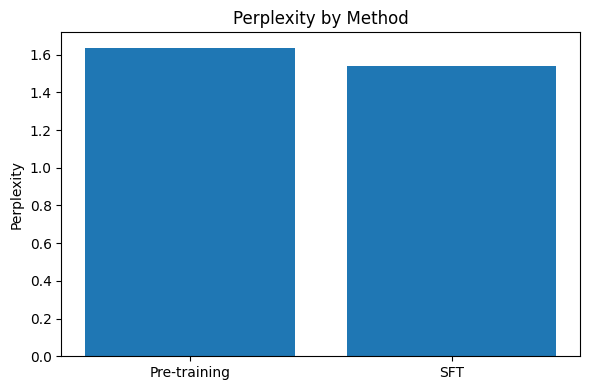

Saved: perplexity_by_method.png


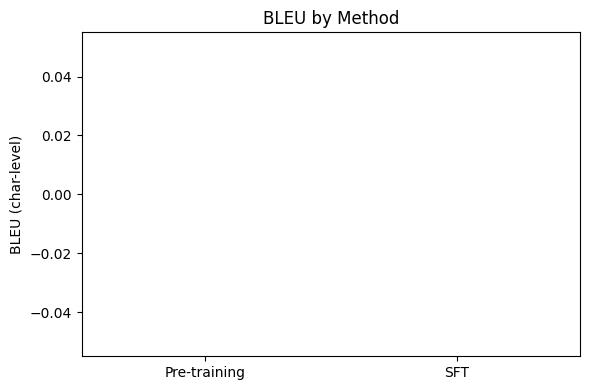

Saved: bleu_by_method.png


In [12]:
# ===== Step 8 — Metrics Table + BLEU (Colab) =====
import sys, subprocess, math, torch, pandas as pd
import matplotlib.pyplot as plt

# 0) Ensure nltk is available for BLEU
try:
    import nltk  # noqa
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "nltk"])
    import nltk
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def perplexity_from_loss(loss):
    return math.exp(loss) if (loss is not None and not math.isnan(loss)) else float("nan")

# 1) Pull metrics from histories (works for either key style)
def pull_last(hist, key_candidates):
    for k in key_candidates:
        if isinstance(hist, dict) and k in hist and len(hist[k])>0:
            return hist[k][-1]
    return float("nan")

pre_train_loss = pull_last(globals().get("history_pre", {}), ["train","train_loss"])
pre_val_loss   = pull_last(globals().get("history_pre", {}), ["val","val_loss"])
sft_train_loss = pull_last(globals().get("history_sft", {}), ["train","train_loss"])
sft_val_loss   = pull_last(globals().get("history_sft", {}), ["val","val_loss"])

ppl_pre = perplexity_from_loss(pre_val_loss)
ppl_sft = perplexity_from_loss(sft_val_loss)

# 2) BLEU for SFT completions (character-level, on sft_val_loader)
def sft_bleu_char(model, loader, encode, decode, max_eval_pairs=64, temperature=0.9):
    if loader is None: return float("nan")
    model.eval()
    refs, hyps = [], []
    chencherry = SmoothingFunction()
    with torch.no_grad():
        pairs_count = 0
        for X, Y, instrs, targs in loader:
            for i in range(len(instrs)):
                instr_text = decode(instrs[i])
                targ_text  = decode(targs[i])

                # Generate completion conditioned on the instruction (cap length to target len)
                idx = torch.tensor([encode(instr_text)], dtype=torch.long, device=next(model.parameters()).device)
                Tm = getattr(model, "block_size", 64)
                for _ in range(len(targs[i])):
                    logits = model(idx)[:, -1, :]
                    if temperature != 1.0:
                        logits = logits / max(1e-6, temperature)
                    probs = torch.softmax(logits, dim=-1)
                    next_id = torch.multinomial(probs, 1)
                    idx = torch.cat([idx, next_id], dim=1)
                    if idx.size(1) > Tm:  # keep within context window
                        idx = idx[:, -Tm:]
                full = decode(idx[0].tolist())
                comp = full[len(instr_text):]

                refs.append([list(targ_text)])  # reference(s) as list of tokens (chars)
                hyps.append(list(comp))         # hypothesis as list of tokens (chars)
                pairs_count += 1
                if pairs_count >= max_eval_pairs:
                    break
            if pairs_count >= max_eval_pairs:
                break
    try:
        return float(corpus_bleu(refs, hyps, smoothing_function=chencherry.method1))
    except Exception:
        return float("nan")

bleu_sft = sft_bleu_char(globals().get("model", None),
                         globals().get("sft_val_loader", None),
                         globals().get("encode", None),
                         globals().get("decode", None),
                         max_eval_pairs=64,
                         temperature=0.9)

# 3) Results table
df_results = pd.DataFrame([
    {"Method": "Pre-training",
     "Final_Train_Loss": pre_train_loss,
     "Val_Loss": pre_val_loss,
     "Perplexity": ppl_pre,
     "BLEU": float("nan"),
     "Notes": "Unsupervised LM on WikiText-2 (fast slice)"},
    {"Method": "SFT",
     "Final_Train_Loss": sft_train_loss,
     "Val_Loss": sft_val_loss,
     "Perplexity": ppl_sft,
     "BLEU": bleu_sft,
     "Notes": "Instruction→answer pairs; masked loss; char-level"}
])

print("\n=== Results Table ===")
display(df_results)

# 4) Save CSV (+ download)
CSV_PATH = "Assignment4_results.csv"
df_results.to_csv(CSV_PATH, index=False)
print("Saved:", CSV_PATH)

try:
    from google.colab import files
    files.download(CSV_PATH)
except Exception:
    pass  # skip auto-download if not in Colab

# 5) (Optional) quick bar chart image for report
try:
    # Bar: Perplexity and BLEU (normalize BLEU to show alongside)
    methods = list(df_results["Method"])
    ppl_vals = [float(df_results.loc[i, "Perplexity"]) if pd.notna(df_results.loc[i, "Perplexity"]) else float("nan")
                for i in range(len(df_results))]
    bleu_vals = [float(df_results.loc[i, "BLEU"]) if pd.notna(df_results.loc[i, "BLEU"]) else 0.0
                 for i in range(len(df_results))]

    # Plot two separate charts to avoid mixed scales
    plt.figure()
    plt.bar(methods, ppl_vals)
    plt.title("Perplexity by Method"); plt.ylabel("Perplexity"); plt.tight_layout()
    plt.savefig("perplexity_by_method.png", dpi=150); plt.show()
    print("Saved: perplexity_by_method.png")

    plt.figure()
    plt.bar(methods, bleu_vals)
    plt.title("BLEU by Method"); plt.ylabel("BLEU (char-level)"); plt.tight_layout()
    plt.savefig("bleu_by_method.png", dpi=150); plt.show()
    print("Saved: bleu_by_method.png")
except Exception as e:
    print("Plotting skipped:", e)


**Step 9: RL-lite (toy REINFORCE with a keyword reward)**




=== RL-lite (REINFORCE) starting ===
[RL] step 1/40  reward=-0.012  contains_keyword=False
   prompt: 'The future of AI '
   completion: 'Se ufupuIoupuubeutupuufuuruuA=ppumiy uuuppiptpp' ...
[RL] step 10/40  reward=-0.014  contains_keyword=False
   prompt: 'In this study, we '
   completion: ' usie ssss sssstssssssq sssssss sssssscsssssst' ...
[RL] step 20/40  reward=-0.025  contains_keyword=False
   prompt: 'Recent advances in NLP '
   completion: 'smlc vam , m ss Th , s . =trmpr s Vws NpP' ...
[RL] step 30/40  reward=-0.014  contains_keyword=False
   prompt: 'In this study, we '
   completion: 'tusimuitt t thi tt theutttttt ettttttttttttttt' ...
[RL] step 40/40  reward=-0.025  contains_keyword=False
   prompt: 'Recent advances in NLP '
   completion: 'wd ml "e  . , . eme mmemtem bememessme te' ...
RL-lite time: 8.7s


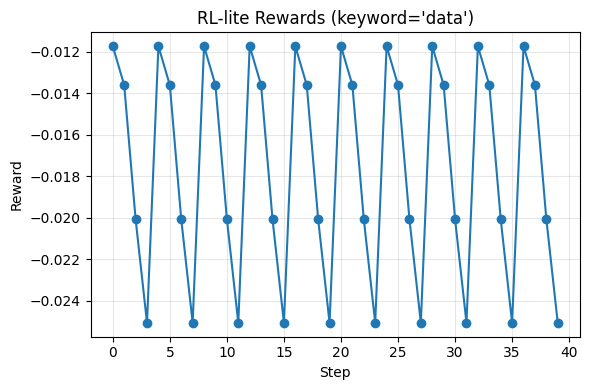

Saved plot -> rl_reward.png

=== After RL-lite — qualitative checks ===

Prompt: 'The future of AI '
Completion: 'ueu futuntunubefu unfufu ufubuutufuunuttuntunut' ...
Contains 'data'? -> False

Prompt: 'In this study, we '
Completion: ' us   sis is s , s m s , , ,  sis , s ss ss ss' ...
Contains 'data'? -> False

Prompt: 'Our results indicate '
Completion: 'tttsidtst ts tititsuditstittttttttttttttttt' ...
Contains 'data'? -> False

Prompt: 'Recent advances in NLP '
Completion: 'in mp mev me . meve emempomppppppompppppo' ...
Contains 'data'? -> False


In [15]:
# ===== Step 9 — RL-lite (REINFORCE toy), single cell =====
# Goal: Nudge the model to include a chosen keyword in completions using a tiny REINFORCE loop.
# Safe for Colab (small steps), length-clamped to model.block_size, and logs rewards.

import torch, math, time
import torch.nn.functional as F
import matplotlib.pyplot as plt

assert "model" in globals(), "Run Steps 3–7 first (model + SFT)."
assert "encode" in globals() and "decode" in globals(), "Tokenizer missing (run Step 2)."

device = next(model.parameters()).device
Tm = getattr(model, "block_size", 64)   # model context length

# --- Config (keep small/fast) ---
keyword = "data"          # the behavior to encourage
target_len = 60           # approx completion length
rl_steps = 40             # number of updates (keep small)
rl_lr = 1e-4              # small LR for stability
temperature = 0.9         # sampling temp in rollout

prompts = [
    "The future of AI ",
    "In this study, we ",
    "Our results indicate ",
    "Recent advances in NLP ",
]

# --- Reward: +1 if keyword present (case-insensitive), gentle length shaping near target ---
def reward_fn(text, keyword=keyword, target_len=target_len):
    t = text.lower()
    r_kw = 1.0 if keyword.lower() in t else 0.0
    # mild length reward (parabola centered at target_len)
    diff = len(text) - target_len
    r_len = - (diff * diff) / (target_len * target_len + 1e-6) * 0.25  # small magnitude
    return float(r_kw + r_len)

# --- Rollout: sample tokens and accumulate logprobs (policy gradient) ---
@torch.no_grad()
def rollout_text(model, prompt_text, gen_len=target_len, temperature=temperature):
    model.eval()
    idx = torch.tensor([encode(prompt_text)], dtype=torch.long, device=device)
    logprobs = []
    for _ in range(gen_len):
        logits = model(idx)[:, -1, :]
        if temperature != 1.0:
            logits = logits / max(1e-6, temperature)
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, 1)               # sample action
        lp = torch.log(torch.gather(probs, 1, next_id) + 1e-12)  # log pi(a|s)
        logprobs.append(lp.squeeze(1))                      # (B,)
        idx = torch.cat([idx, next_id], dim=1)
        if idx.size(1) > Tm:                                # clamp context
            idx = idx[:, -Tm:]
    text = decode(idx[0].tolist())
    return text, torch.stack(logprobs, dim=0)  # (T, B=1)

# --- Optimizer for RL stage (continue from SFT weights) ---
rl_opt = torch.optim.AdamW(model.parameters(), lr=rl_lr)

# --- Track rewards for a tiny plot ---
rewards_hist = []

print("=== RL-lite (REINFORCE) starting ===")
t0 = time.time()
for step in range(1, rl_steps + 1):
    model.train(); rl_opt.zero_grad()
    prompt = prompts[(step - 1) % len(prompts)]

    # Rollout with grad-tracking for the policy (we need grads through logits)
    # We'll re-run with grad enabled for the logprob path:
    idx = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
    logprob_sum = 0.0
    for _ in range(target_len):
        logits = model(idx)[:, -1, :]
        if temperature != 1.0:
            logits = logits / max(1e-6, temperature)
        probs = torch.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, 1)
        lp = torch.log(torch.gather(probs, 1, next_id) + 1e-12)  # (B,1)
        logprob_sum = logprob_sum + lp.mean()                    # scalar
        idx = torch.cat([idx, next_id], dim=1)
        if idx.size(1) > Tm:
            idx = idx[:, -Tm:]
    # decode final
    full = decode(idx[0].tolist())
    completion = full[len(prompt):]

    # Reward and policy gradient
    R = reward_fn(completion, keyword=keyword, target_len=target_len)
    loss = -(R * logprob_sum)   # maximize E[R * log pi]  -> minimize negative
    loss.backward()
    rl_opt.step()

    rewards_hist.append(R)

    if step % 10 == 0 or step == 1:
        contains = keyword.lower() in completion.lower()
        print(f"[RL] step {step}/{rl_steps}  reward={R:.3f}  contains_keyword={contains}")
        print("   prompt:", repr(prompt))
        print("   completion:", repr(completion[:120]), "...")

print(f"RL-lite time: {time.time()-t0:.1f}s")

# --- Tiny reward plot saved for report ---
plt.figure()
plt.plot(rewards_hist, marker="o")
plt.title(f"RL-lite Rewards (keyword='{keyword}')")
plt.xlabel("Step"); plt.ylabel("Reward"); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig("rl_reward.png", dpi=150); plt.show()
print("Saved plot -> rl_reward.png")

# --- Qualitative before/after (greedy for readability) ---
@torch.no_grad()
def greedy_complete(model, prompt_text, max_new_tokens=target_len):
    idx = torch.tensor([encode(prompt_text)], dtype=torch.long, device=device)
    for _ in range(max_new_tokens):
        logits = model(idx)[:, -1, :]
        next_id = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat([idx, next_id], dim=1)
        if idx.size(1) > Tm:
            idx = idx[:, -Tm:]
    full = decode(idx[0].tolist())
    return full[len(prompt_text):]

print("\n=== After RL-lite — qualitative checks ===")
for p in prompts:
    comp = greedy_complete(model, p, max_new_tokens=target_len)
    print("\nPrompt:", repr(p))
    print("Completion:", repr(comp[:160]), "...")
    print(f"Contains '{keyword}'? ->", keyword.lower() in comp.lower())
